NetworkX version: 3.4.2
Attempting to load: C:\Users\Public\projects\Belief_propagation_simulator_\configs\factor_graphs\factor-graph-cycle-3-random_intlow1,high100-number5.pkl
File does not exist: C:\Users\Public\projects\Belief_propagation_simulator_\configs\factor_graphs\factor-graph-cycle-3-random_intlow1,high100-number5.pkl
Available factor graph files in C:\Users\Public\projects\Belief_propagation_simulator_\configs\factor_graphs:
  - factor-graph-cycle-3-random_intlow100,high2000.3-number0.pkl
Using first available file: C:\Users\Public\projects\Belief_propagation_simulator_\configs\factor_graphs\factor-graph-cycle-3-random_intlow100,high2000.3-number0.pkl
Graph loaded. Type: <class 'bp_base.factor_graph.FactorGraph'>

Factor graph details:
Variables: 3
Factors: 3
Graph nodes: 6
Graph edges: 6

First few nodes:
  - X1
  - X2
  - X3
  - F12
  - F23

First variable: x1, Domain: 3

First factor: f12
Cost table shape: (3, 3)

Repaired graph saved to: C:\Users\Public\projects\Belief_

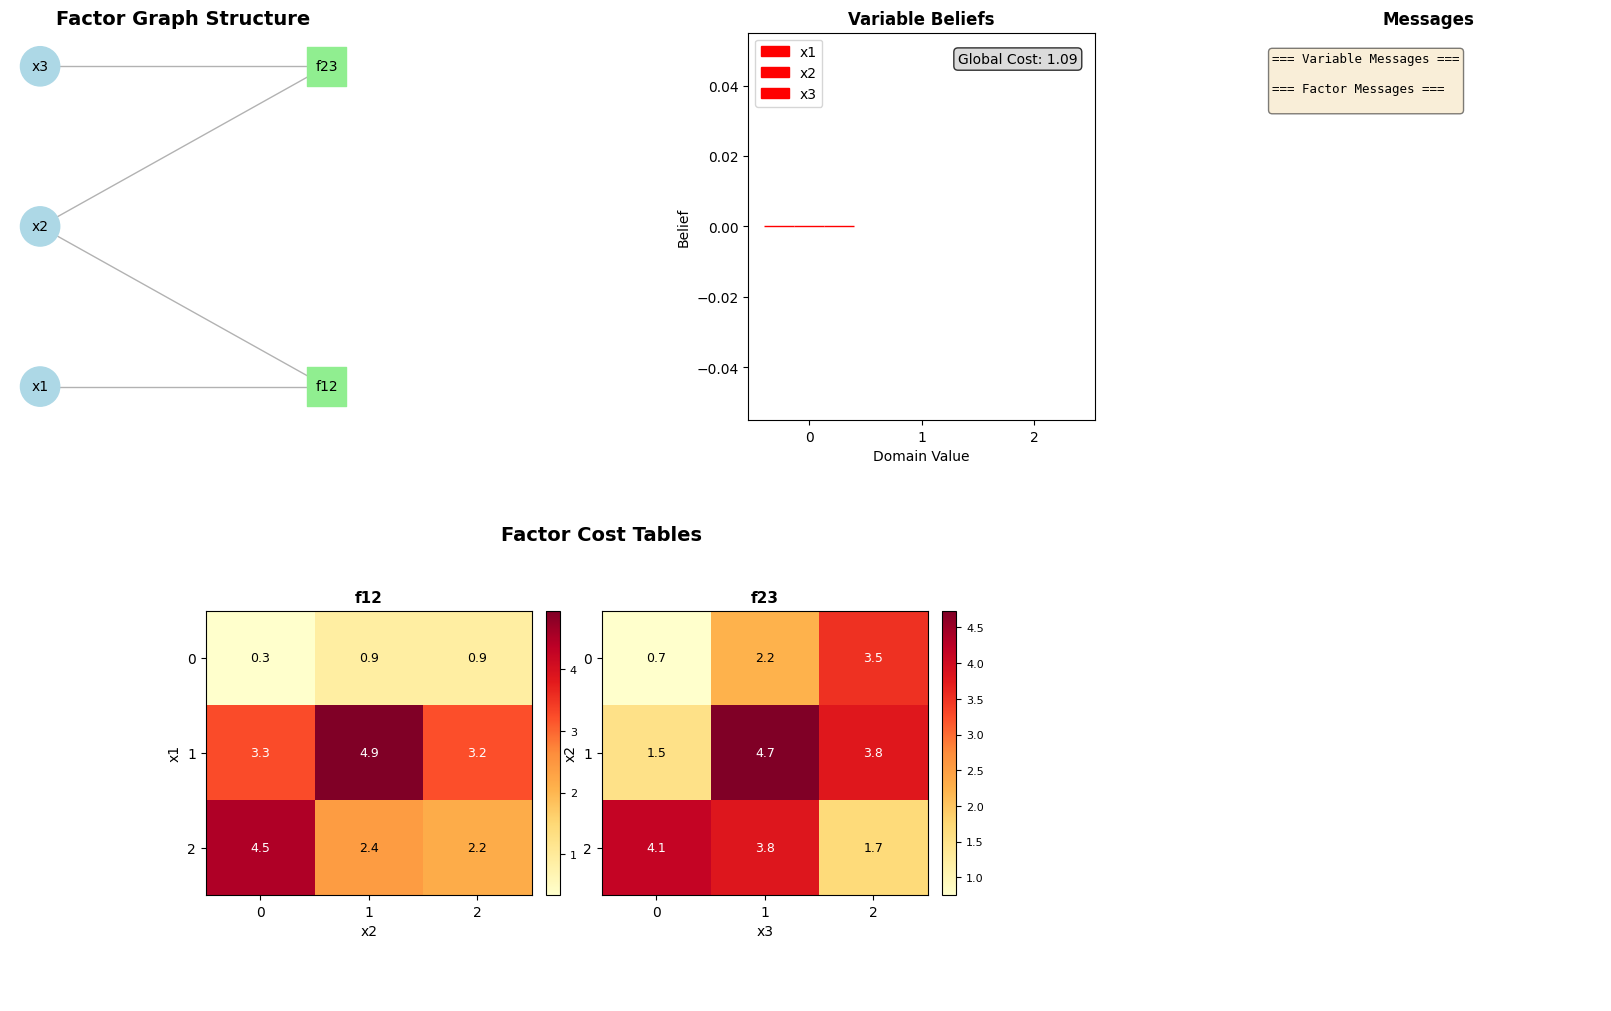

In [1]:
# Interactive Belief Propagation Message Passing Visualizer
# This notebook provides step-by-step visualization of BP algorithms

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch
import networkx as nx
from IPython.display import display, clear_output
import ipywidgets as widgets
from typing import Dict, List, Tuple, Optional
import pickle
from pathlib import Path

# Import your BP modules
import sys
sys.path.append('..')  # Adjust path as needed

from bp_base.factor_graph import FactorGraph
from bp_base.agents import VariableAgent, FactorAgent
from bp_base.components import Message
from bp_base.computators import MinSumComputator, MaxSumComputator
from bp_base.bp_engine_base import BPEngine
from utils.path_utils import find_project_root

class BPVisualizer:
    """Interactive visualizer for belief propagation message passing."""

    def __init__(self, engine: BPEngine, figsize=(16, 10)):
        self.engine = engine
        self.graph = engine.graph
        self.figsize = figsize

        # State tracking
        self.current_cycle = 0
        self.current_step = 0
        self.max_steps_per_cycle = self.graph.diameter + 1
        self.phase = "idle"  # idle, var_compute, var_send, factor_compute, factor_send

        # Store intermediate states
        self.step_states = []
        self.current_state = None

        # Layout
        self.pos = self._compute_layout()

        # UI elements
        self.fig = None
        self.axes = None
        self.widgets = None

    def _compute_layout(self):
        """Compute a bipartite layout for the factor graph."""
        return nx.bipartite_layout(
            self.graph.G,
            nodes=[n for n in self.graph.G.nodes() if isinstance(n, VariableAgent)],
            scale=2.0
        )

    def _create_ui(self):
        """Create interactive UI controls."""
        # Control buttons
        self.btn_next = widgets.Button(description="Next Phase", button_style='primary')
        self.btn_prev = widgets.Button(description="Previous Phase", button_style='warning')
        self.btn_reset = widgets.Button(description="Reset", button_style='danger')
        self.btn_run_step = widgets.Button(description="Run Full Step", button_style='success')

        # Info labels
        self.lbl_cycle = widgets.Label(value=f"Cycle: {self.current_cycle}")
        self.lbl_step = widgets.Label(value=f"Step: {self.current_step}/{self.max_steps_per_cycle-1}")
        self.lbl_phase = widgets.Label(value=f"Phase: {self.phase}")
        self.lbl_cost = widgets.Label(value=f"Global Cost: --")

        # Speed control
        self.speed_slider = widgets.FloatSlider(
            value=1.0, min=0.1, max=3.0, step=0.1,
            description='Animation Speed:', style={'description_width': 'initial'}
        )

        # Checkboxes for display options
        self.chk_show_beliefs = widgets.Checkbox(value=True, description='Show Beliefs')
        self.chk_show_messages = widgets.Checkbox(value=True, description='Show Messages')
        self.chk_show_tables = widgets.Checkbox(value=True, description='Show Cost Tables')
        self.chk_highlight_active = widgets.Checkbox(value=True, description='Highlight Active')

        # Button callbacks
        self.btn_next.on_click(self._on_next_phase)
        self.btn_prev.on_click(self._on_prev_phase)
        self.btn_reset.on_click(self._on_reset)
        self.btn_run_step.on_click(self._on_run_step)

        # Layout
        controls = widgets.HBox([
            self.btn_prev, self.btn_next, self.btn_run_step, self.btn_reset
        ])
        info = widgets.HBox([
            self.lbl_cycle, self.lbl_step, self.lbl_phase, self.lbl_cost
        ])
        options = widgets.HBox([
            self.chk_show_beliefs, self.chk_show_messages,
            self.chk_show_tables, self.chk_highlight_active
        ])

        self.widgets = widgets.VBox([controls, info, self.speed_slider, options])

    def _capture_state(self):
        """Capture current state of the factor graph."""
        state = {
            'cycle': self.current_cycle,
            'step': self.current_step,
            'phase': self.phase,
            'beliefs': {},
            'messages': {},
            'cost_tables': {},
            'assignments': {},
            'global_cost': self.graph.global_cost
        }

        # Capture variable states
        for var in self.graph.variables:
            state['beliefs'][var.name] = var.belief.copy()
            state['assignments'][var.name] = var.curr_assignment
            state['messages'][var.name] = {
                'inbox': [(m.sender.name, m.data.copy()) for m in var.mailer.inbox],
                'outbox': [(m.recipient.name, m.data.copy()) for m in var.mailer.outbox]
            }

        # Capture factor states
        for factor in self.graph.factors:
            if factor.cost_table is not None:
                state['cost_tables'][factor.name] = factor.cost_table.copy()
            state['messages'][factor.name] = {
                'inbox': [(m.sender.name, m.data.copy()) for m in factor.mailer.inbox],
                'outbox': [(m.recipient.name, m.data.copy()) for m in factor.mailer.outbox]
            }

        return state

    def _draw_graph(self, ax):
        """Draw the factor graph structure."""
        # Draw edges
        nx.draw_networkx_edges(self.graph.G, self.pos, ax=ax, alpha=0.3)

        # Draw variable nodes
        var_nodes = [n for n in self.graph.G.nodes() if isinstance(n, VariableAgent)]
        var_colors = []
        for var in var_nodes:
            if self.chk_highlight_active.value and self.phase == "var_compute":
                var_colors.append('lightcoral' if var in self._get_active_nodes() else 'lightblue')
            else:
                var_colors.append('lightblue')

        nx.draw_networkx_nodes(
            self.graph.G, self.pos, nodelist=var_nodes,
            node_shape='o', node_color=var_colors, node_size=800, ax=ax
        )

        # Draw factor nodes
        factor_nodes = [n for n in self.graph.G.nodes() if isinstance(n, FactorAgent)]
        factor_colors = []
        for factor in factor_nodes:
            if self.chk_highlight_active.value and self.phase == "factor_compute":
                factor_colors.append('lightcoral' if factor in self._get_active_nodes() else 'lightgreen')
            else:
                factor_colors.append('lightgreen')

        nx.draw_networkx_nodes(
            self.graph.G, self.pos, nodelist=factor_nodes,
            node_shape='s', node_color=factor_colors, node_size=800, ax=ax
        )

        # Draw labels
        labels = {n: n.name for n in self.graph.G.nodes()}
        nx.draw_networkx_labels(self.graph.G, self.pos, labels, ax=ax, font_size=10)

        ax.set_title("Factor Graph Structure", fontsize=14, fontweight='bold')
        ax.axis('off')

    def _draw_beliefs(self, ax):
        """Draw current beliefs for variable nodes."""
        if not self.chk_show_beliefs.value:
            ax.axis('off')
            return

        state = self.current_state
        var_names = sorted([v.name for v in self.graph.variables])

        if not var_names:
            ax.text(0.5, 0.5, "No variables", ha='center', va='center')
            ax.axis('off')
            return

        # Clear the axis
        ax.clear()

        # Create bar chart for beliefs
        n_vars = len(var_names)
        domain_size = self.graph.variables[0].domain

        # Set up bar positions
        bar_width = 0.8 / n_vars
        x_base = np.arange(domain_size)

        # Plot each variable's belief
        for i, var_name in enumerate(var_names):
            belief = state['beliefs'].get(var_name, np.ones(domain_size))
            assignment = state['assignments'].get(var_name, 0)

            # Calculate x offset for this variable
            x_offset = (i - n_vars/2 + 0.5) * bar_width
            x_pos = x_base + x_offset

            # Plot bars
            bars = ax.bar(x_pos, belief, bar_width, label=var_name, alpha=0.7)

            # Highlight current assignment
            if assignment < len(bars):
                bars[assignment].set_color('red')
                bars[assignment].set_alpha(1.0)

        # Labels and formatting
        ax.set_xlabel("Domain Value")
        ax.set_ylabel("Belief")
        ax.set_title("Variable Beliefs", fontsize=12, fontweight='bold')
        ax.set_xticks(x_base)
        ax.legend()

        # Add global cost
        global_cost = state.get('global_cost', 0)
        ax.text(0.95, 0.95, f"Global Cost: {global_cost:.2f}",
                transform=ax.transAxes, ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    def _draw_messages(self, ax):
        """Draw current messages."""
        if not self.chk_show_messages.value:
            ax.axis('off')
            return

        ax.clear()
        state = self.current_state

        # Collect all messages
        message_text = []

        # Messages from variables
        message_text.append("=== Variable Messages ===\n")
        for var_name in sorted([v.name for v in self.graph.variables]):
            msgs = state['messages'].get(var_name, {})
            if msgs.get('outbox'):
                message_text.append(f"{var_name} sends:\n")
                for recipient, data in msgs['outbox']:
                    message_text.append(f"  → {recipient}: {data}\n")

        # Messages from factors
        message_text.append("\n=== Factor Messages ===\n")
        for factor_name in sorted([f.name for f in self.graph.factors]):
            msgs = state['messages'].get(factor_name, {})
            if msgs.get('outbox'):
                message_text.append(f"{factor_name} sends:\n")
                for recipient, data in msgs['outbox']:
                    message_text.append(f"  → {recipient}: {data}\n")

        # Display messages
        ax.text(0.05, 0.95, ''.join(message_text),
                transform=ax.transAxes, fontsize=9,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        ax.set_title("Messages", fontsize=12, fontweight='bold')
        ax.axis('off')

    def _draw_cost_tables(self, ax):
        """Draw cost tables for factor nodes."""
        if not self.chk_show_tables.value:
            ax.clear()
            ax.axis('off')
            return

        # Get axis position if we need to recreate
        if not hasattr(self, 'axes_positions'):
            self.axes_positions = {}
        if 3 not in self.axes_positions:
            self.axes_positions[3] = ax.get_position()

        # Get factor nodes
        factors = sorted(self.graph.factors, key=lambda f: f.name)
        if not factors:
            ax.clear()
            ax.text(0.5, 0.5, "No factors", ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
            return

        # Clear axis content but keep it
        ax.clear()
        ax.axis('off')

        # Show first few factors
        max_factors = 4
        factors_to_show = factors[:max_factors]

        n_factors = len(factors_to_show)
        if n_factors == 0:
            return

        # Get position for subplots
        pos = self.axes_positions[3]

        # Calculate grid layout
        cols = min(2, n_factors)
        rows = (n_factors + cols - 1) // cols

        # Create subaxes manually
        width = pos.width / cols * 0.9
        height = pos.height / rows * 0.85

        for idx, factor in enumerate(factors_to_show):
            row_idx = idx // cols
            col_idx = idx % cols

            # Calculate position
            left = pos.x0 + col_idx * (pos.width / cols)
            bottom = pos.y1 - (row_idx + 1) * (pos.height / rows)

            # Create sub-axis
            sub_ax = self.fig.add_axes([left, bottom, width, height])

            # Get cost table
            if factor.cost_table is None:
                sub_ax.text(0.5, 0.5, "No cost table", ha='center', va='center',
                           transform=sub_ax.transAxes)
                sub_ax.axis('off')
                continue

            ct = factor.cost_table

            # For 2D tables, show as heatmap
            if ct.ndim == 2:
                im = sub_ax.imshow(ct, cmap='YlOrRd', aspect='auto', interpolation='nearest')

                # Add text annotations
                for i in range(ct.shape[0]):
                    for j in range(ct.shape[1]):
                        color = 'white' if ct[i, j] > ct.max()/2 else 'black'
                        sub_ax.text(j, i, f'{ct[i, j]:.1f}',
                                   ha="center", va="center", color=color, fontsize=9)

                # Get variable names for labels
                var_names = list(factor.connection_number.keys())
                if len(var_names) >= 2:
                    sub_ax.set_xlabel(var_names[1], fontsize=10)
                    sub_ax.set_ylabel(var_names[0], fontsize=10)

                sub_ax.set_xticks(range(ct.shape[1]))
                sub_ax.set_yticks(range(ct.shape[0]))

                # Add colorbar
                cbar = plt.colorbar(im, ax=sub_ax, fraction=0.046, pad=0.04)
                cbar.ax.tick_params(labelsize=8)

            elif ct.ndim == 1:
                # For 1D tables, show as bar chart
                bars = sub_ax.bar(range(len(ct)), ct, color='coral', edgecolor='darkred')
                sub_ax.set_xlabel("Value", fontsize=10)
                sub_ax.set_ylabel("Cost", fontsize=10)
                sub_ax.set_xticks(range(len(ct)))

                # Add value labels on bars
                for i, bar in enumerate(bars):
                    height = bar.get_height()
                    sub_ax.text(bar.get_x() + bar.get_width()/2., height,
                               f'{ct[i]:.1f}', ha='center', va='bottom', fontsize=8)
            else:
                # For higher dimensional, show summary
                sub_ax.text(0.5, 0.5, f"Shape: {ct.shape}\nMin: {ct.min():.2f}\n"
                           f"Max: {ct.max():.2f}\nMean: {ct.mean():.2f}",
                           ha='center', va='center', transform=sub_ax.transAxes,
                           bbox=dict(boxstyle='round', facecolor='wheat'))
                sub_ax.axis('off')

            sub_ax.set_title(f"{factor.name}", fontsize=11, fontweight='bold')

        # Add title
        self.fig.text((pos.x0 + pos.x1)/2, pos.y1 + 0.02, "Factor Cost Tables",
                fontsize=14, fontweight='bold', ha='center')

    def _draw_r_message_computation(self, ax):
        """Draw detailed R message computation showing marginalization."""
        if not self.chk_show_tables.value or self.phase != "factor_compute":
            ax.axis('off')
            return

        ax.clear()

        # Get active factors (those computing messages)
        active_factors = [f for f in self.graph.factors if len(f.mailer.outbox) > 0]

        if not active_factors:
            ax.text(0.5, 0.5, "No R messages being computed", ha='center', va='center')
            ax.axis('off')
            return

        # Show first factor's computation in detail
        factor = active_factors[0]

        # Get cost table and messages
        cost_table = self.current_state['cost_tables'].get(factor.name)
        if cost_table is None or cost_table.ndim != 2:  # Focus on 2D for clarity
            ax.text(0.5, 0.5, f"Factor {factor.name}: Cost table not 2D", ha='center', va='center')
            ax.axis('off')
            return

        # Get messages
        incoming_msgs = self.current_state['messages'][factor.name]['inbox']
        outgoing_msgs = self.current_state['messages'][factor.name]['outbox']

        if not outgoing_msgs:
            ax.axis('off')
            return

        # Get axis position and remove it
        ax_pos = ax.get_position()
        fig = ax.figure
        ax.remove()

        # Create new gridspec for R message details
        n_recipients = min(2, len(outgoing_msgs))  # Show max 2
        gs_r = fig.add_gridspec(1, n_recipients,
                               left=ax_pos.x0, right=ax_pos.x1,
                               bottom=ax_pos.y0, top=ax_pos.y1,
                               wspace=0.3)

        for idx, (recipient_name, out_msg_data) in enumerate(outgoing_msgs[:n_recipients]):
            # Create subplot
            subax = fig.add_subplot(gs_r[0, idx])

            # Show augmented cost table
            augmented = cost_table.copy()

            # Add incoming messages from OTHER variables
            highlight_dim = None
            for sender_name, in_msg_data in incoming_msgs:
                if sender_name != recipient_name:
                    # Find dimension for this sender
                    sender_dim = None
                    for var_name, dim in factor.connection_number.items():
                        if var_name == sender_name:
                            sender_dim = dim
                            break

                    if sender_dim is not None:
                        if sender_dim == 0:  # Rows
                            augmented += in_msg_data.reshape(-1, 1)
                        else:  # Columns
                            augmented += in_msg_data.reshape(1, -1)
                else:
                    # This is the recipient dimension
                    for var_name, dim in factor.connection_number.items():
                        if var_name == recipient_name:
                            highlight_dim = dim
                            break

            # Visualize augmented table with marginalization
            im = subax.imshow(augmented, cmap='YlOrRd', aspect='auto')

            # Highlight marginalization
            if highlight_dim is not None:
                if highlight_dim == 0:  # Marginalizing over columns
                    for i in range(augmented.shape[0]):
                        min_j = np.argmin(augmented[i, :])
                        rect = patches.Rectangle((min_j-0.4, i-0.4), 0.8, 0.8,
                                               linewidth=3, edgecolor='blue',
                                               facecolor='none')
                        subax.add_patch(rect)
                else:  # Marginalizing over rows
                    for j in range(augmented.shape[1]):
                        min_i = np.argmin(augmented[:, j])
                        rect = patches.Rectangle((j-0.4, min_i-0.4), 0.8, 0.8,
                                               linewidth=3, edgecolor='blue',
                                               facecolor='none')
                        subax.add_patch(rect)

            # Add value annotations
            for i in range(augmented.shape[0]):
                for j in range(augmented.shape[1]):
                    color = 'white' if augmented[i, j] > augmented.max()/2 else 'black'
                    subax.text(j, i, f'{augmented[i, j]:.1f}',
                             ha="center", va="center", color=color, fontsize=8)

            # Show resulting R message
            result_text = f"R→{recipient_name}: {out_msg_data.round(2)}"
            subax.text(0.5, -0.15, result_text, transform=subax.transAxes,
                      ha='center', va='top', fontweight='bold', color='blue',
                      bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

            # Labels
            var_names = list(factor.connection_number.keys())
            if len(var_names) >= 2:
                subax.set_xlabel(var_names[1])
                subax.set_ylabel(var_names[0])
            subax.set_title(f"{factor.name} → {recipient_name}", fontsize=10)

            # Add colorbar
            plt.colorbar(im, ax=subax, fraction=0.046, pad=0.04)

        # Add title
        fig.text((ax_pos.x0 + ax_pos.x1)/2, ax_pos.y1 + 0.02,
                f"R Message Computation: {factor.name}",
                fontsize=12, fontweight='bold', ha='center')

    def _get_active_nodes(self):
        """Get currently active nodes based on phase."""
        if self.phase == "var_compute":
            return self.graph.variables
        elif self.phase == "factor_compute":
            return self.graph.factors
        return []

    def _update_display(self):
        """Update the visualization."""
        if self.fig is None:
            return

        # Update labels
        self.lbl_cycle.value = f"Cycle: {self.current_cycle}"
        self.lbl_step.value = f"Step: {self.current_step}/{self.max_steps_per_cycle-1}"
        self.lbl_phase.value = f"Phase: {self.phase}"
        self.lbl_cost.value = f"Global Cost: {self.current_state['global_cost']:.2f}"

        # Clear and redraw main axes
        for i, ax in enumerate(self.axes[:3]):  # Only clear the first 3 main axes
            ax.clear()

        # Draw components
        self._draw_graph(self.axes[0])
        self._draw_beliefs(self.axes[1])
        self._draw_messages(self.axes[2])

        # Handle cost tables and R message computation separately
        # since they recreate their own sub-axes
        if len(self.axes) > 3:
            self._draw_cost_tables(self.axes[3])

        if self.phase == "factor_compute" and len(self.axes) > 4:
            self._draw_r_message_computation(self.axes[4])
        elif len(self.axes) > 4:
            # Clear any existing R message axes
            self.axes[4].clear()
            self.axes[4].axis('off')

        # Don't use tight_layout with constrained_layout
        plt.draw()

    def _execute_phase(self):
        """Execute the current phase of BP."""
        if self.phase == "var_compute":
            # Variables compute messages
            for var in self.graph.variables:
                var.compute_messages()
                self.engine.post_var_compute(var)

        elif self.phase == "var_send":
            # Variables send messages
            for var in self.graph.variables:
                var.mailer.send()

        elif self.phase == "var_clear":
            # Clear variable mailboxes
            for var in self.graph.variables:
                var.empty_mailbox()
                var.mailer.prepare()

        elif self.phase == "factor_compute":
            # Factors compute messages
            for factor in self.graph.factors:
                factor.compute_messages()
                self.engine.post_factor_step()

        elif self.phase == "factor_send":
            # Factors send messages
            for factor in self.graph.factors:
                factor.mailer.send()

        elif self.phase == "factor_clear":
            # Clear factor mailboxes
            for factor in self.graph.factors:
                factor.empty_mailbox()
                factor.mailer.prepare()

    def _advance_phase(self):
        """Advance to the next phase."""
        phases = ["idle", "var_compute", "var_send", "var_clear",
                 "factor_compute", "factor_send", "factor_clear"]

        current_idx = phases.index(self.phase)
        next_idx = (current_idx + 1) % len(phases)

        if next_idx == 0:  # Completed a full step
            self.current_step += 1
            if self.current_step >= self.max_steps_per_cycle:
                self.current_step = 0
                self.current_cycle += 1

                # Run post-cycle operations
                if self.current_cycle == 2:
                    self.engine.post_two_cycles()
                self.engine.post_var_cycle()
                self.engine.post_factor_cycle()

        self.phase = phases[next_idx]

        # Execute the phase
        self._execute_phase()

        # Capture state
        self.current_state = self._capture_state()

    def _on_next_phase(self, b):
        """Handle next phase button click."""
        self._advance_phase()
        self._update_display()

    def _on_prev_phase(self, b):
        """Handle previous phase button click."""
        # For simplicity, just show a message
        print("Previous phase not implemented yet")

    def _on_reset(self, b):
        """Handle reset button click."""
        # Reset all nodes
        for var in self.graph.variables:
            var.empty_mailbox()
            var.empty_outgoing()
            var.mailer._incoming.clear()
            var.mailer._outgoing.clear()
            # Reinitialize zero messages
            for neighbor in self.graph.G.neighbors(var):
                var.mailer.set_first_message(var, neighbor)

        for factor in self.graph.factors:
            factor.empty_mailbox()
            factor.empty_outgoing()
            factor.mailer._incoming.clear()
            factor.mailer._outgoing.clear()

        # Reset counters
        self.current_cycle = 0
        self.current_step = 0
        self.phase = "idle"

        # Clear history
        self.engine.history.cycles.clear()
        self.engine.history.beliefs.clear()
        self.engine.history.assignments.clear()
        self.engine.history.costs.clear()

        # Capture initial state
        self.current_state = self._capture_state()
        self._update_display()

    def _on_run_step(self, b):
        """Run a complete step automatically."""
        # Run through all phases of one step
        start_step = self.current_step
        while self.current_step == start_step:
            self._advance_phase()

        self._update_display()

    def run(self):
        """Run the interactive visualizer."""
        # Create UI
        self._create_ui()

        # Create figure with constrained layout (avoids tight_layout issues)
        self.fig = plt.figure(figsize=self.figsize)
        self.fig.set_constrained_layout(True)
        gs = self.fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

        # Create placeholder axes
        self.axes = [
            self.fig.add_subplot(gs[0, 0]),  # Graph
            self.fig.add_subplot(gs[0, 1]),  # Beliefs
            self.fig.add_subplot(gs[0, 2]),  # Messages
            self.fig.add_subplot(gs[1, :2]), # Cost Tables (span 2 columns)
            self.fig.add_subplot(gs[1, 2])   # R Message Computation
        ]

        # Store original positions for axes that will be recreated
        self.axes_positions = {
            3: self.axes[3].get_position(),
            4: self.axes[4].get_position()
        }

        # Initial state
        self.current_state = self._capture_state()

        # Initial display
        self._update_display()

        # Display widgets
        display(self.widgets)
        plt.show()


# Example usage function
def run_bp_visualizer(factor_graph_path: str, computator_type: str = "min-sum"):
    """
    Run the BP visualizer with a factor graph.

    Args:
        factor_graph_path: Path to pickled factor graph
        computator_type: "min-sum" or "max-sum"
    """
    # Load factor graph
    with open(factor_graph_path, 'rb') as f:
        factor_graph = pickle.load(f)

    # Create computator
    if computator_type == "min-sum":
        computator = MinSumComputator()
    else:
        computator = MaxSumComputator()

    # Create engine
    engine = BPEngine(factor_graph, computator=computator)

    # Create and run visualizer
    visualizer = BPVisualizer(engine)
    visualizer.run()


# Example: Create a simple factor graph for testing
def create_simple_test_graph():
    """Create a simple 3-variable chain factor graph for testing."""
    from bp_base.agents import VariableAgent, FactorAgent
    from bp_base.factor_graph import FactorGraph

    # Create variables
    x1 = VariableAgent("x1", domain=3)
    x2 = VariableAgent("x2", domain=3)
    x3 = VariableAgent("x3", domain=3)

    # Create factors with random cost tables
    def random_cost(n_vars, domain, **kwargs):
        shape = tuple([domain] * n_vars)
        return np.random.rand(*shape) * 10

    f12 = FactorAgent("f12", domain=3, ct_creation_func=random_cost, param={})
    f23 = FactorAgent("f23", domain=3, ct_creation_func=random_cost, param={})

    # Define edges
    edges = {
        f12: [x1, x2],
        f23: [x2, x3]
    }

    # Create factor graph
    fg = FactorGraph(
        variable_li=[x1, x2, x3],
        factor_li=[f12, f23],
        edges=edges
    )

    return fg


# Quick start example
if __name__ == "__main__":
    # Create a simple test graph
    fg = create_simple_test_graph()

    # Create engine
    engine = BPEngine(fg, computator=MinSumComputator())

    # Run visualizer
    visualizer = BPVisualizer(engine)
    visualizer.run()